In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor

In [91]:
import joblib

In [162]:
raw_data = pd.read_csv('additionalData.csv', sep=';')
target_cols = raw_data.columns[0:12]
target = raw_data.loc[:,target_cols]

In [163]:
data = raw_data.drop(target_cols, axis=1)

In [164]:
for c in target_cols:
    target[c]=target[c].apply(lambda x: x.replace(',','.'))
    target[c] = pd.to_numeric(target[c])
    
for c in data.columns:
    data[c]=data[c].apply(lambda x: x.replace(',','.'))
    data[c] = pd.to_numeric(data[c])

In [256]:
train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size=0.2, random_state=42)

In [257]:
scaler = StandardScaler()
sc_train_data = scaler.fit_transform(train_data)
sc_test_data = scaler.transform(test_data)

In [258]:
sc_train_data.shape

(800, 25)

In [102]:
def draw_grid(model, grid, param, X,y,cv=5, multy=False, draw_std=False):
    param_grid = {param:grid}
    search = GridSearchCV(model, param_grid=param_grid, cv=cv,
                          scoring='neg_mean_squared_error',n_jobs=-1,
                          refit=True).fit(X,y)


    means = abs(search.cv_results_['mean_test_score'])
    error = search.cv_results_['std_test_score']

    plt.figure(figsize=(15,8))
    plt.title('choose '+param)

    plt.plot(grid, means, label='mean squared error', color='red', lw=3)
    if draw_std:
        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green',
                         label='filled area between errors', alpha=0.5)
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.xlabel('parameter')
    plt.ylabel('MSE')
    plt.show()
    return search

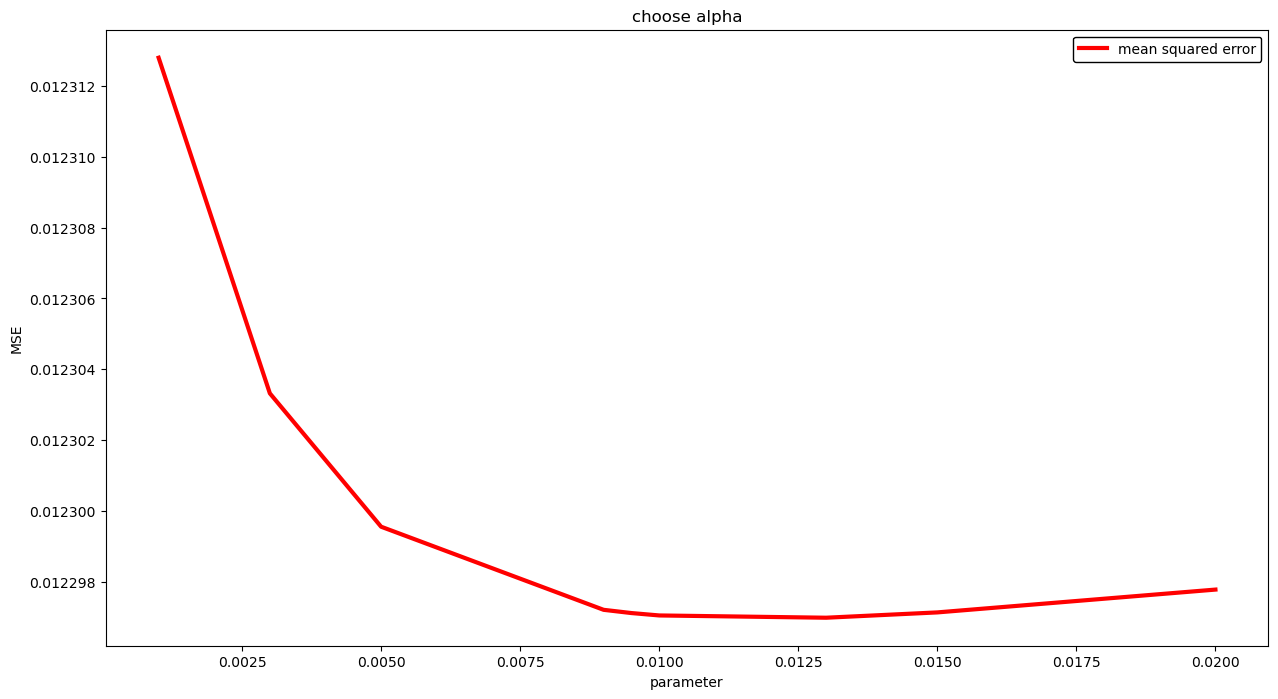

In [170]:
grid=[0.001,0.003,0.005,0.009,0.0095,0.01,0.013,0.015,0.02]
param="alpha"
Ridge_reg_grid = draw_grid(Ridge(), grid, param, sc_train_data, train_labels)

In [171]:
Ridge_reg_grid.best_estimator_

Ridge(alpha=0.013)

In [172]:
mean_squared_error(test_labels, Ridge_reg_grid.best_estimator_.predict(scaler.transform(test_data)))

0.012497793507493799

In [181]:
grid=[0.025,0.027,0.03,0.033,0.035,0.037,0.04]
means = []
for lr in tqdm(grid):
    cat = CatBoostRegressor(loss_function='MultiRMSE', verbose=1000, thread_count=-1, learning_rate=lr ).fit(sc_train_data,train_labels)
    means.append(mean_squared_error(test_labels, cat.predict(scaler.transform(test_data))))
    

  0%|          | 0/7 [00:00<?, ?it/s]

0:	learn: 0.8727935	total: 102ms	remaining: 1m 41s
999:	learn: 0.2691877	total: 23.7s	remaining: 0us
0:	learn: 0.8723857	total: 25.1ms	remaining: 25.1s
999:	learn: 0.2537931	total: 22.7s	remaining: 0us
0:	learn: 0.8717750	total: 22.3ms	remaining: 22.3s
999:	learn: 0.2360679	total: 23.2s	remaining: 0us
0:	learn: 0.8711655	total: 27.6ms	remaining: 27.6s
999:	learn: 0.2205275	total: 23.1s	remaining: 0us
0:	learn: 0.8707599	total: 23.3ms	remaining: 23.2s
999:	learn: 0.2096374	total: 23.1s	remaining: 0us
0:	learn: 0.8703547	total: 22.3ms	remaining: 22.3s
999:	learn: 0.1998066	total: 22.7s	remaining: 0us
0:	learn: 0.8697480	total: 30.5ms	remaining: 30.5s
999:	learn: 0.1870330	total: 23.4s	remaining: 0us


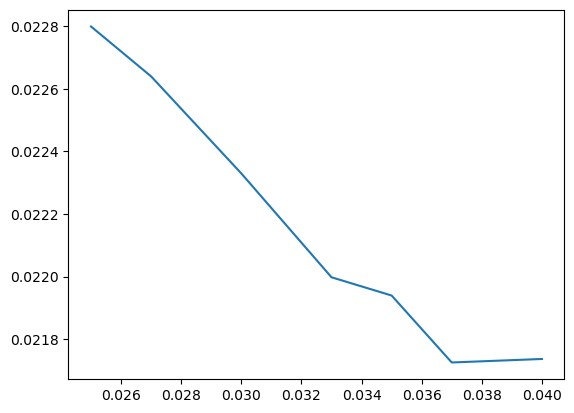

In [182]:
plt.plot(grid, means)
plt.show()

In [183]:
print(np.argmin(means))

5


In [42]:
%%time
grid = {'learning_rate': [0.001,0.01,0.05,0.1,0.2,0.5],
        'depth': [4, 6, 10],
        'n_estimators':[1200],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cat = CatBoostRegressor(loss_function='MultiRMSE', verbose=100, thread_count=-1)


grid_search_result = cat.grid_search(grid,
                                       X=sc_train_data, 
                                       y=train_labels, 
                                       plot=True)






Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3922593	test: 2.3860966	best: 2.3860966 (0)	total: 25ms	remaining: 30s
100:	learn: 2.1947709	test: 2.1892401	best: 2.1892401 (100)	total: 896ms	remaining: 9.75s
200:	learn: 2.0181237	test: 2.0132763	best: 2.0132763 (200)	total: 1.73s	remaining: 8.58s
300:	learn: 1.8600339	test: 1.8559185	best: 1.8559185 (300)	total: 2.52s	remaining: 7.54s
400:	learn: 1.7193679	test: 1.7160006	best: 1.7160006 (400)	total: 3.23s	remaining: 6.44s
500:	learn: 1.5941080	test: 1.5914841	best: 1.5914841 (500)	total: 4s	remaining: 5.58s
600:	learn: 1.4828545	test: 1.4809865	best: 1.4809865 (600)	total: 4.8s	remaining: 4.79s
700:	learn: 1.3842034	test: 1.3831034	best: 1.3831034 (700)	total: 5.68s	remaining: 4.04s
800:	learn: 1.2970725	test: 1.2967653	best: 1.2967653 (800)	total: 6.4s	remaining: 3.19s
900:	learn: 1.2200773	test: 1.2205598	best: 1.2205598 (900)	total: 7.18s	remaining: 2.38s
1000:	learn: 1.1522480	test: 1.1535374	best: 1.1535374 (1000)	total: 8.02s	remaining: 1.59s
1100:	learn: 1.09267

600:	learn: 1.4848051	test: 1.4829709	best: 1.4829709 (600)	total: 4.58s	remaining: 4.57s
700:	learn: 1.3862370	test: 1.3851698	best: 1.3851698 (700)	total: 5.29s	remaining: 3.77s
800:	learn: 1.2991390	test: 1.2988628	best: 1.2988628 (800)	total: 5.99s	remaining: 2.98s
900:	learn: 1.2221521	test: 1.2226635	best: 1.2226635 (900)	total: 6.68s	remaining: 2.22s
1000:	learn: 1.1543107	test: 1.1556294	best: 1.1556294 (1000)	total: 7.54s	remaining: 1.5s
1100:	learn: 1.0946888	test: 1.0967927	best: 1.0967927 (1100)	total: 8.28s	remaining: 744ms
1199:	learn: 1.0430612	test: 1.0459031	best: 1.0459031 (1199)	total: 9.07s	remaining: 0us

bestTest = 1.045903078
bestIteration = 1199

6:	loss: 1.0459031	best: 0.4223645 (4)	total: 1m 6s	remaining: 13m 11s
0:	learn: 2.3734677	test: 2.3673581	best: 2.3673581 (0)	total: 12.4ms	remaining: 14.9s
100:	learn: 1.1479799	test: 1.1492931	best: 1.1492931 (100)	total: 833ms	remaining: 9.06s
200:	learn: 0.8007077	test: 0.8083460	best: 0.8083460 (200)	total: 1.6s	r

1199:	learn: 1.0448707	test: 1.0477226	best: 1.0477226 (1199)	total: 9.2s	remaining: 0us

bestTest = 1.047722553
bestIteration = 1199

12:	loss: 1.0477226	best: 0.4206588 (10)	total: 2m 3s	remaining: 12m 12s
0:	learn: 2.3735299	test: 2.3674214	best: 2.3674214 (0)	total: 13.3ms	remaining: 16s
100:	learn: 1.1495965	test: 1.1509332	best: 1.1509332 (100)	total: 735ms	remaining: 8s
200:	learn: 0.8017443	test: 0.8093975	best: 0.8093975 (200)	total: 1.62s	remaining: 8.04s
300:	learn: 0.7046801	test: 0.7150733	best: 0.7150733 (300)	total: 2.32s	remaining: 6.94s
400:	learn: 0.6650605	test: 0.6765900	best: 0.6765900 (400)	total: 3.12s	remaining: 6.23s
500:	learn: 0.6403572	test: 0.6525474	best: 0.6525474 (500)	total: 3.92s	remaining: 5.47s
600:	learn: 0.6217367	test: 0.6344041	best: 0.6344041 (600)	total: 4.82s	remaining: 4.8s
700:	learn: 0.6061476	test: 0.6191566	best: 0.6191566 (700)	total: 5.74s	remaining: 4.09s
800:	learn: 0.5930288	test: 0.6066026	best: 0.6066026 (800)	total: 6.77s	remainin

400:	learn: 0.6658576	test: 0.6773401	best: 0.6773401 (400)	total: 3.01s	remaining: 6s
500:	learn: 0.6411252	test: 0.6532149	best: 0.6532149 (500)	total: 3.71s	remaining: 5.18s
600:	learn: 0.6225899	test: 0.6351197	best: 0.6351197 (600)	total: 4.62s	remaining: 4.61s
700:	learn: 0.6071512	test: 0.6200386	best: 0.6200386 (700)	total: 5.31s	remaining: 3.78s
800:	learn: 0.5943424	test: 0.6078010	best: 0.6078010 (800)	total: 6.04s	remaining: 3.01s
900:	learn: 0.5827965	test: 0.5967695	best: 0.5967695 (900)	total: 6.74s	remaining: 2.24s
1000:	learn: 0.5723317	test: 0.5868129	best: 0.5868129 (1000)	total: 7.44s	remaining: 1.48s
1100:	learn: 0.5627608	test: 0.5778252	best: 0.5778252 (1100)	total: 8.25s	remaining: 742ms
1199:	learn: 0.5539344	test: 0.5696003	best: 0.5696003 (1199)	total: 8.98s	remaining: 0us

bestTest = 0.569600286
bestIteration = 1199

19:	loss: 0.5696003	best: 0.4200839 (16)	total: 3m 9s	remaining: 11m 3s
0:	learn: 2.2907975	test: 2.2849384	best: 2.2849384 (0)	total: 13.5ms	r

1000:	learn: 0.5733759	test: 0.5877488	best: 0.5877488 (1000)	total: 8.49s	remaining: 1.69s
1100:	learn: 0.5640003	test: 0.5789151	best: 0.5789151 (1100)	total: 9.3s	remaining: 836ms
1199:	learn: 0.5552010	test: 0.5707356	best: 0.5707356 (1199)	total: 9.98s	remaining: 0us

bestTest = 0.5707356079
bestIteration = 1199

25:	loss: 0.5707356	best: 0.4200839 (16)	total: 4m 7s	remaining: 10m 8s
0:	learn: 2.2910928	test: 2.2852336	best: 2.2852336 (0)	total: 12.9ms	remaining: 15.5s
100:	learn: 0.6420308	test: 0.6545233	best: 0.6545233 (100)	total: 872ms	remaining: 9.49s
200:	learn: 0.5734176	test: 0.5882344	best: 0.5882344 (200)	total: 1.56s	remaining: 7.75s
300:	learn: 0.5335626	test: 0.5509183	best: 0.5509183 (300)	total: 2.31s	remaining: 6.89s
400:	learn: 0.5064767	test: 0.5270751	best: 0.5270751 (400)	total: 3.13s	remaining: 6.23s
500:	learn: 0.4878121	test: 0.5112112	best: 0.5112112 (500)	total: 3.8s	remaining: 5.3s
600:	learn: 0.4728568	test: 0.4989621	best: 0.4989621 (600)	total: 4.47s	

100:	learn: 0.5869493	test: 0.6102726	best: 0.6102726 (100)	total: 3.14s	remaining: 34.2s
200:	learn: 0.5125638	test: 0.5472429	best: 0.5472429 (200)	total: 6.02s	remaining: 29.9s
300:	learn: 0.4658072	test: 0.5134611	best: 0.5134611 (300)	total: 8.83s	remaining: 26.4s
400:	learn: 0.4343108	test: 0.4929566	best: 0.4929566 (400)	total: 11.7s	remaining: 23.3s
500:	learn: 0.4101787	test: 0.4787939	best: 0.4787939 (500)	total: 14.6s	remaining: 20.4s
600:	learn: 0.3908138	test: 0.4693960	best: 0.4693960 (600)	total: 17.6s	remaining: 17.6s
700:	learn: 0.3742868	test: 0.4620501	best: 0.4620501 (700)	total: 20.8s	remaining: 14.8s
800:	learn: 0.3601342	test: 0.4565316	best: 0.4565316 (800)	total: 24.2s	remaining: 12.1s
900:	learn: 0.3471698	test: 0.4520122	best: 0.4520122 (900)	total: 27.5s	remaining: 9.11s
1000:	learn: 0.3354490	test: 0.4485246	best: 0.4485246 (1000)	total: 31.1s	remaining: 6.18s
1100:	learn: 0.3246790	test: 0.4455457	best: 0.4455457 (1100)	total: 34.9s	remaining: 3.14s
1199:	

700:	learn: 0.3891239	test: 0.4658807	best: 0.4658807 (700)	total: 21.3s	remaining: 15.2s
800:	learn: 0.3757419	test: 0.4598702	best: 0.4598702 (800)	total: 24.3s	remaining: 12.1s
900:	learn: 0.3636537	test: 0.4547042	best: 0.4547042 (900)	total: 27.3s	remaining: 9.05s
1000:	learn: 0.3527180	test: 0.4506246	best: 0.4506246 (1000)	total: 30.3s	remaining: 6.02s
1100:	learn: 0.3425570	test: 0.4470672	best: 0.4470672 (1100)	total: 33.3s	remaining: 3s
1199:	learn: 0.3328053	test: 0.4439764	best: 0.4439763 (1198)	total: 36.3s	remaining: 0us

bestTest = 0.4439762754
bestIteration = 1198

38:	loss: 0.4439763	best: 0.4191143 (28)	total: 10m 57s	remaining: 14m 19s
0:	learn: 2.1862142	test: 2.1813382	best: 2.1813382 (0)	total: 28.2ms	remaining: 33.8s
100:	learn: 0.5188620	test: 0.5502536	best: 0.5502536 (100)	total: 3.01s	remaining: 32.8s
200:	learn: 0.4456634	test: 0.4984096	best: 0.4984096 (200)	total: 5.83s	remaining: 29s
300:	learn: 0.4056187	test: 0.4759436	best: 0.4759436 (300)	total: 8.87s

100:	learn: 0.5232066	test: 0.5531908	best: 0.5531908 (100)	total: 2.81s	remaining: 30.6s
200:	learn: 0.4537164	test: 0.5019653	best: 0.5019653 (200)	total: 5.61s	remaining: 27.9s
300:	learn: 0.4141425	test: 0.4781601	best: 0.4781601 (300)	total: 8.43s	remaining: 25.2s
400:	learn: 0.3873556	test: 0.4651634	best: 0.4651634 (400)	total: 11.2s	remaining: 22.4s
500:	learn: 0.3642928	test: 0.4559355	best: 0.4559355 (500)	total: 14.2s	remaining: 19.8s
600:	learn: 0.3449479	test: 0.4497184	best: 0.4497184 (600)	total: 17s	remaining: 17s
700:	learn: 0.3284966	test: 0.4445086	best: 0.4445086 (700)	total: 20s	remaining: 14.2s
800:	learn: 0.3134878	test: 0.4405366	best: 0.4405214 (799)	total: 22.8s	remaining: 11.4s
900:	learn: 0.2998512	test: 0.4368306	best: 0.4368306 (900)	total: 25.7s	remaining: 8.52s
1000:	learn: 0.2878174	test: 0.4344589	best: 0.4344455 (999)	total: 28.5s	remaining: 5.67s
1100:	learn: 0.2764024	test: 0.4323030	best: 0.4322155 (1094)	total: 31.4s	remaining: 2.82s
1199:	learn: 

700:	learn: 0.3380213	test: 0.4455544	best: 0.4455290 (698)	total: 20.1s	remaining: 14.3s
800:	learn: 0.3235249	test: 0.4414712	best: 0.4414712 (800)	total: 23s	remaining: 11.5s
900:	learn: 0.3102364	test: 0.4382722	best: 0.4382722 (900)	total: 25.9s	remaining: 8.58s
1000:	learn: 0.2983184	test: 0.4355389	best: 0.4355291 (999)	total: 28.7s	remaining: 5.71s
1100:	learn: 0.2872191	test: 0.4333889	best: 0.4333556 (1097)	total: 31.4s	remaining: 2.82s
1199:	learn: 0.2766249	test: 0.4314500	best: 0.4314500 (1199)	total: 34.2s	remaining: 0us

bestTest = 0.4314500459
bestIteration = 1199

51:	loss: 0.4314500	best: 0.4191143 (28)	total: 18m 56s	remaining: 13m 50s
0:	learn: 1.9876489	test: 1.9842358	best: 1.9842358 (0)	total: 27ms	remaining: 32.3s
100:	learn: 0.4636944	test: 0.5096522	best: 0.5096522 (100)	total: 2.86s	remaining: 31.1s
200:	learn: 0.3982777	test: 0.4722831	best: 0.4722831 (200)	total: 5.81s	remaining: 28.9s
300:	learn: 0.3585489	test: 0.4567995	best: 0.4567995 (300)	total: 8.71s

100:	learn: 0.4686966	test: 0.5104301	best: 0.5104301 (100)	total: 3.02s	remaining: 32.9s
200:	learn: 0.4060636	test: 0.4727771	best: 0.4727771 (200)	total: 5.94s	remaining: 29.5s
300:	learn: 0.3661113	test: 0.4550702	best: 0.4550702 (300)	total: 8.85s	remaining: 26.4s
400:	learn: 0.3357610	test: 0.4459724	best: 0.4459644 (397)	total: 11.6s	remaining: 23.2s
500:	learn: 0.3107360	test: 0.4406974	best: 0.4406251 (498)	total: 14.4s	remaining: 20.1s
600:	learn: 0.2887320	test: 0.4360739	best: 0.4360739 (600)	total: 17.3s	remaining: 17.2s
700:	learn: 0.2706650	test: 0.4332719	best: 0.4332365 (699)	total: 20.2s	remaining: 14.4s
800:	learn: 0.2540792	test: 0.4308663	best: 0.4308663 (800)	total: 23.1s	remaining: 11.5s
900:	learn: 0.2394027	test: 0.4295248	best: 0.4293942 (894)	total: 26s	remaining: 8.63s
1000:	learn: 0.2252418	test: 0.4280699	best: 0.4280699 (1000)	total: 28.9s	remaining: 5.74s
1100:	learn: 0.2128197	test: 0.4270304	best: 0.4269384 (1098)	total: 31.6s	remaining: 2.85s
1199:	le

600:	learn: 0.0240834	test: 0.4970584	best: 0.4970584 (600)	total: 4m 33s	remaining: 4m 32s
700:	learn: 0.0159091	test: 0.4969526	best: 0.4969412 (691)	total: 5m 24s	remaining: 3m 50s
800:	learn: 0.0105866	test: 0.4968426	best: 0.4968279 (774)	total: 6m 10s	remaining: 3m 4s
900:	learn: 0.0071357	test: 0.4967878	best: 0.4967878 (900)	total: 6m 54s	remaining: 2m 17s
1000:	learn: 0.0047647	test: 0.4967604	best: 0.4967559 (960)	total: 7m 36s	remaining: 1m 30s
1100:	learn: 0.0032116	test: 0.4967492	best: 0.4967488 (1099)	total: 8m 16s	remaining: 44.7s
1199:	learn: 0.0021890	test: 0.4967477	best: 0.4967445 (1117)	total: 9m	remaining: 0us

bestTest = 0.4967444866
bestIteration = 1117

64:	loss: 0.4967445	best: 0.4191143 (28)	total: 1h 7m 13s	remaining: 25m 51s
0:	learn: 1.3863191	test: 1.4016404	best: 1.4016404 (0)	total: 407ms	remaining: 8m 8s
100:	learn: 0.1404658	test: 0.5532198	best: 0.5532198 (100)	total: 45.3s	remaining: 8m 12s
200:	learn: 0.0455642	test: 0.5526138	best: 0.5525640 (197)

KeyboardInterrupt: 

In [184]:
best_model = CatBoostRegressor(loss_function='MultiRMSE', 
                               verbose=100, thread_count=-1, n_estimators=1500, 
                               learning_rate=grid[np.argmin(means)] ).fit(sc_train_data,train_labels)

0:	learn: 0.8703547	total: 66ms	remaining: 1m 38s
100:	learn: 0.5760196	total: 2.68s	remaining: 37.2s
200:	learn: 0.4803564	total: 4.93s	remaining: 31.9s
300:	learn: 0.4138708	total: 7.21s	remaining: 28.7s
400:	learn: 0.3624968	total: 9.47s	remaining: 25.9s
500:	learn: 0.3230131	total: 11.7s	remaining: 23.3s
600:	learn: 0.2917970	total: 14s	remaining: 20.9s
700:	learn: 0.2634250	total: 16.3s	remaining: 18.6s
800:	learn: 0.2394851	total: 18.5s	remaining: 16.1s
900:	learn: 0.2186066	total: 20.8s	remaining: 13.8s
1000:	learn: 0.1996682	total: 23.1s	remaining: 11.5s
1100:	learn: 0.1829736	total: 25.3s	remaining: 9.17s
1200:	learn: 0.1683398	total: 27.6s	remaining: 6.87s
1300:	learn: 0.1549743	total: 29.8s	remaining: 4.56s
1400:	learn: 0.1428726	total: 32.1s	remaining: 2.27s
1499:	learn: 0.1322716	total: 34.3s	remaining: 0us


In [125]:
best_model.save_model('CatBoost1.pkl')

In [126]:
best_model.predict(scaler.transform(test_data)).shape

(200, 12)

In [127]:
df = best_model.get_feature_importance(prettified=True)
df['Feature']=data.columns[df['Feature Id'].values.astype(int)]
df.drop(['Feature Id'],axis=1).head()

,Importances,Feature
0,10.195835,QPlant_2
1,9.962367,QPlant_3
2,8.909674,QPlant_4
3,7.468568,Q_8
4,6.919132,QPlant_1


In [128]:
mean_squared_error(test_labels, best_model.predict(scaler.transform(test_data)))

0.02104477595955064

In [185]:
test_data.iloc[0:5].to_csv('Test_data.csv', index=False, sep=';')

In [146]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [145]:
joblib.dump(Ridge_reg_grid.best_estimator_, 'ridge_reg.pkl') 

['ridge_reg.pkl']

In [179]:
scaler = joblib.load('scaler.pkl')
model = joblib.load('ridge_reg.pkl')
df = pd.read_csv('Test_data.csv', )
result = pd.DataFrame(model.predict(scaler.transform(df.values)),columns=['valve_'+str(i) for i in range(1,13)])
result

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,valve_11,valve_12
0,0.484713,0.166178,0.636434,0.631187,0.504617,0.678304,0.570110,0.793999,0.621734,0.469667,0.327185,0.748016
1,0.810122,0.922703,0.375094,0.471989,0.553360,0.932537,0.821243,0.765500,-0.094289,0.117302,1.104494,0.094336
2,0.567490,0.983925,0.863355,0.913604,0.263708,0.401467,0.739184,0.560208,0.725295,0.605725,0.974874,0.463738
3,0.580628,0.813511,0.689971,0.180748,0.277771,0.884489,0.747953,0.631908,0.713379,0.386900,0.554246,0.328643
4,0.803849,0.760927,0.561190,0.395793,0.903907,0.999023,0.701372,0.703281,0.154095,0.118102,0.839248,0.729308


In [ ]:
df = data[['PGRS_1','PGRS_2','QGRS_1','QGRS_2']

In [275]:
def one_valve(df, target):
    models = []
    scalers = []
    for i in tqdm(target_cols):
        X = data.join(target[i])
        print(X.columns)
        s= StandardScaler().fit(df)
        scalers.append(s)
        X = s.transform(df)
        y = target.drop(i, axis=1)
        m = Ridge(alpha=0.013).fit(X,y)
        models.append(m)
    return models, scalers

def predict_valves(df,i,value, full_data, models):
    for c in full_data.columns:
        if c not in df.columns:
            if c=='Q1':
                df[c]=1.4
            if c=='Q2':
                df[c]=0.65
            if c=='Q3':
                df[c]=0.65
            if c=='Q4':
                df[c]=0.65
            if c=='Q5':
                df[c]=0.65
            if c=='Q6':
                df[c]=3
            if c=='Q7':
                df[c]=1.4
            if c=='Q8':
                df[c]=2
            if c=='QPlant_1':
                df[c]=3.4
            if c=='QPlant_2':
                df[c]=4.4
            if c=='QPlant_3':
                df[c]=4.97
            if c=='QPlant_4':
                df[c]=6.12
            if c=='P_9':
                df[c]=293393
            if c=='P_8':
                df[c]=247195
            if c=='P_7':
                df[c]=287276
            if c=='P_6':
                df[c]=235633
            if c=='P_5':
                df[c]=236057
            if c=='P_4':
                df[c]=233355
            if c=='P_3':
                df[c]=219981
            if c=='P_2':
                df[c]=220688
            if c=='P_1':
                df[c]=243777
    df[str(i)] = value
    print(df)

    preds = models[i].predict(scalers[i].transform(df.values))
    result = preds[0:i]
    result.append(value)
    result.extend(preds[i:-1])
    return result


In [276]:
models, scalers = one_valve(sc_train_data, train_labels)

  0%|          | 0/12 [00:00<?, ?it/s]

Index(['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
       'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
       'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8',
       'valve_1'],
      dtype='object')
Index(['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
       'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
       'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8',
       'valve_2'],
      dtype='object')
Index(['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
       'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
       'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8',
       'valve_3'],
      dtype='object')
Index(['QGRS_1', 'QGRS_2', 'QPlant_1', 'QPlant_2', 'QPlant_3', 'QPlant_4',
       'PGRS_1', 'PGRS_2', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7',
       'P_8', 'P_9', 'Q_1', 'Q_2', 'Q_3', 

In [273]:
test_df = data[['PGRS_1','PGRS_2','QGRS_1','QGRS_2']]
test_sample = test_df.sample(1)
test_sample

,PGRS_1,PGRS_2,QGRS_1,QGRS_2
233,342727.235006,318083.8458,19.063086,14.956944


In [274]:
predict_valves(test_sample,2,0.68,data, models)

            PGRS_1       PGRS_2     QGRS_1     QGRS_2  QPlant_1  QPlant_2  \
233  342727.235006  318083.8458  19.063086  14.956944       3.4       4.4   

     QPlant_3  QPlant_4     P_1     P_2     P_3     P_4     P_5     P_6  \
233      4.97      6.12  243777  220688  219981  233355  236057  235633   

        P_7     P_8     P_9     2  
233  287276  247195  293393  0.68  


ValueError: X has 18 features, but StandardScaler is expecting 25 features as input.